In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing
from sklearn import utils

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedGroupKFold,
    GroupKFold,
    StratifiedKFold
)

from sklearn.model_selection import cross_validate

In [8]:
df = pd.read_csv('insurance.csv')


In [9]:
df = df.drop('children', axis = 1)

In [10]:
df.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,18,male,33.770,no,southeast,1725.55230
2,28,male,33.000,no,southeast,4449.46200
3,33,male,22.705,no,northwest,21984.47061
4,32,male,28.880,no,northwest,3866.85520


In [114]:
def get_prep_data():
    df = pd.read_csv('insurance.csv')
    
    df.drop('children', axis=1, inplace=True)
    df['age'] = df['age'].astype('int64')
    df['sex'] = df['sex'].astype('category')
    df['smoker'] = df['smoker'].astype('category')
    df['region'] = df['region'].astype('category')
    df['bmi'] = df['bmi'].astype('int')
    df['charges'] = df['charges'].astype('int')

#     df['doctor'] = np.random.randint(0, 8, size=len(df))
    holdout_ids = df.sample(n=500, random_state=529).index
    
    train = (
        df.loc[~df.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
#         .sort_values('doctor')
        .reset_index(drop=True)
    )
    
    holdout = (
        df.loc[~df.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
#         .sort_values('doctor')
        .reset_index(drop=True)

    )
    
    return train, holdout

train, holdout = get_prep_data()


In [115]:
train.dtypes

age           int64
sex        category
bmi           int32
smoker     category
region     category
charges       int32
dtype: object

In [116]:
train.head()

,age,sex,bmi,smoker,region,charges
0,47,female,33,no,northwest,10115
1,60,female,28,no,southwest,13224
2,56,male,19,yes,northeast,22412
3,46,female,30,no,southwest,8825
4,51,female,33,no,northeast,9866


In [117]:
train.columns

Index(['age', 'sex', 'bmi', 'smoker', 'region', 'charges'], dtype='object')

In [118]:
def get_X_y(train):

    FEATURES = [
        'age', 
        'sex', 
        'bmi', 
        'smoker', 
        'region', 
        ]

#     GROUPS = 'doctor'

    TARGET = 'charges'

    X = train.loc[:, FEATURES]
    y = train[TARGET]
#     groups = train[GROUPS]
    return X, y

In [119]:
X, y = get_X_y(train)
clf = lgb.LGBMClassifier(n_estimators=100)
clf.fit(X, y)
pred = clf.predict(X)
# pred_prob = clf.predict_proba(X)[:, 1]
pred_prob = clf.predict_proba(X)

In [120]:
pred_prob

array([[1.45484197e-05, 1.20782345e-07, 4.15137771e-05, ...,
        7.91230976e-07, 2.90729331e-07, 1.18003667e-06],
       [5.91242926e-07, 4.35162395e-09, 7.22817106e-07, ...,
        4.05593824e-08, 1.18297416e-08, 8.43941395e-07],
       [3.19532967e-08, 9.67433367e-11, 4.96598287e-08, ...,
        1.73034903e-07, 3.08861440e-09, 5.44687138e-08],
       ...,
       [3.34415880e-07, 2.77626937e-09, 9.54194063e-07, ...,
        2.29276215e-08, 6.68152930e-09, 4.77122818e-07],
       [1.04484113e-07, 9.97284058e-10, 3.44769663e-07, ...,
        3.77663644e-08, 1.32154895e-07, 2.46393888e-08],
       [8.80524071e-07, 6.47962915e-09, 1.07610456e-06, ...,
        4.78923742e-08, 1.76132171e-08, 7.14313468e-08]])

In [63]:
pred_prob.shape

(838, 821)

In [121]:
acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_prob, multi_class='ovr' )
print(f"The score for training set accuracy: {acc_score: 0.4f} and AUC of {auc_score: 0.4f}")

The score for training set accuracy:  0.9749 and AUC of  1.0000


In [122]:
X_holdout = holdout[FEATURES]
y_holdout = holdout[TARGET]

pred = clf.predict(X_holdout)
pred_prob = clf.predict_proba(X_holdout)
acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_prob, multi_class='ovr')
print(f"The score for training set accuracy: {acc_score: 0.4f} and AUC of {auc_score: 0.4f}")


The score for training set accuracy:  0.9749 and AUC of  1.0000


In [92]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
               cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

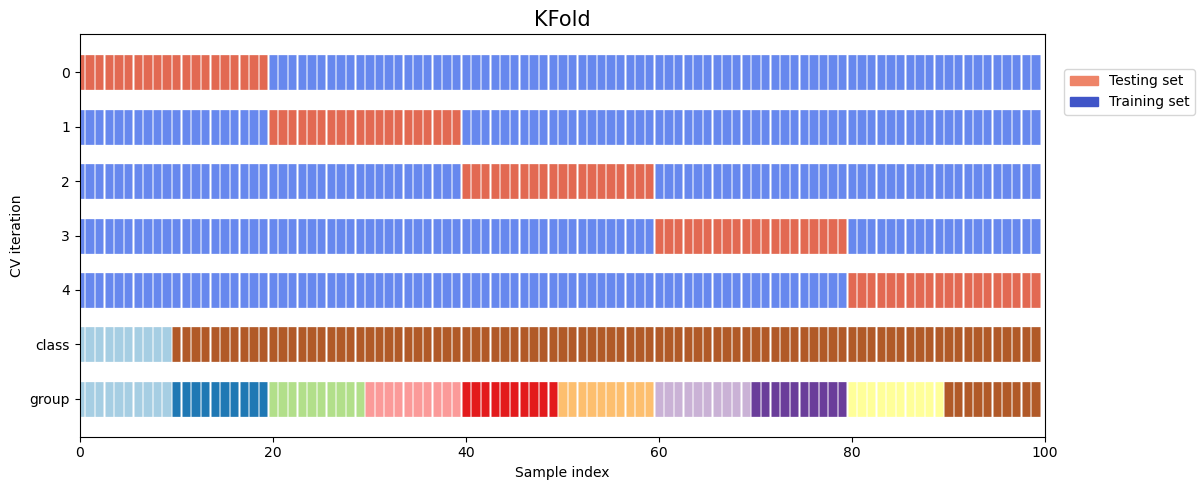

In [125]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

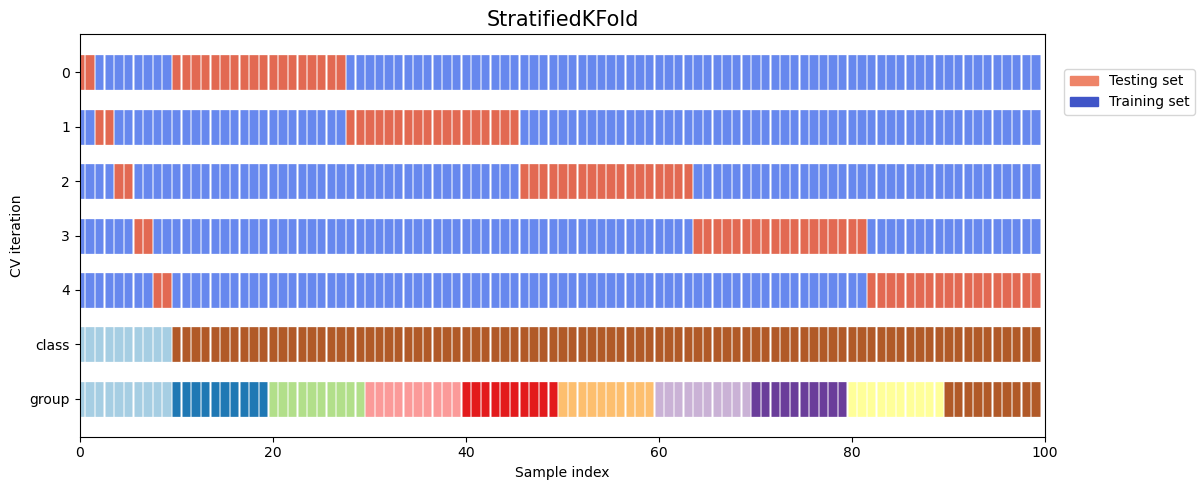

In [126]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

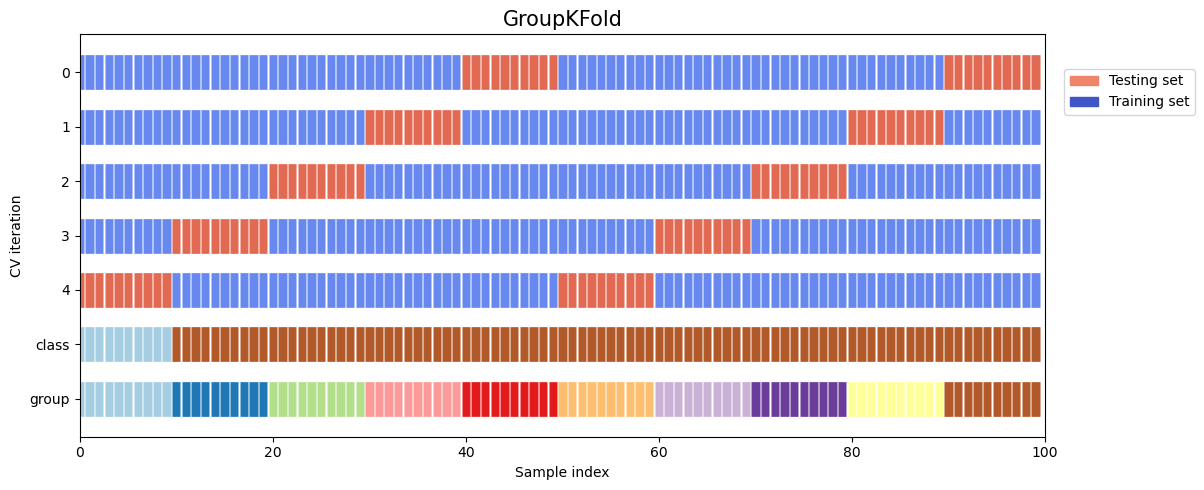

In [127]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

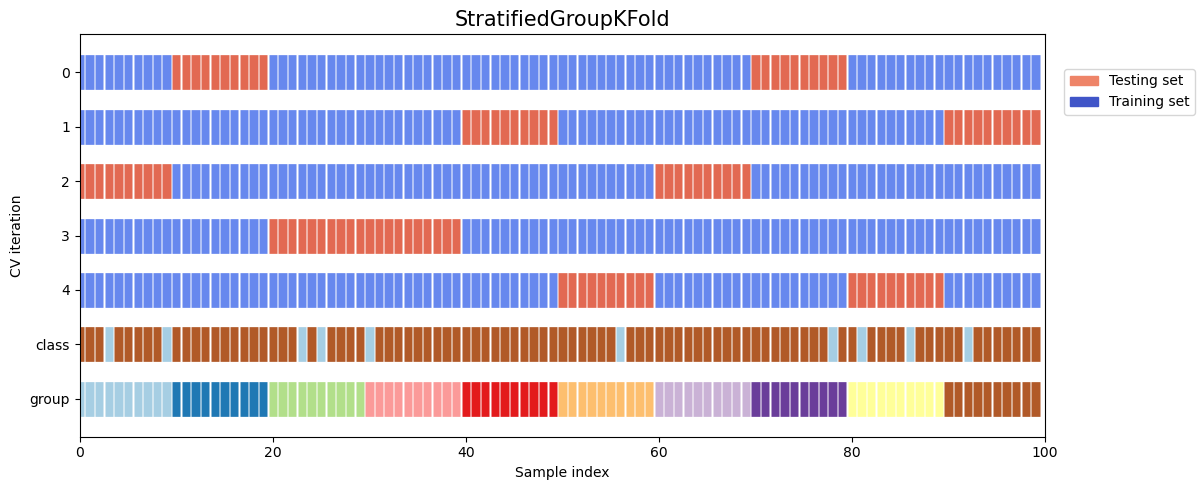

In [128]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

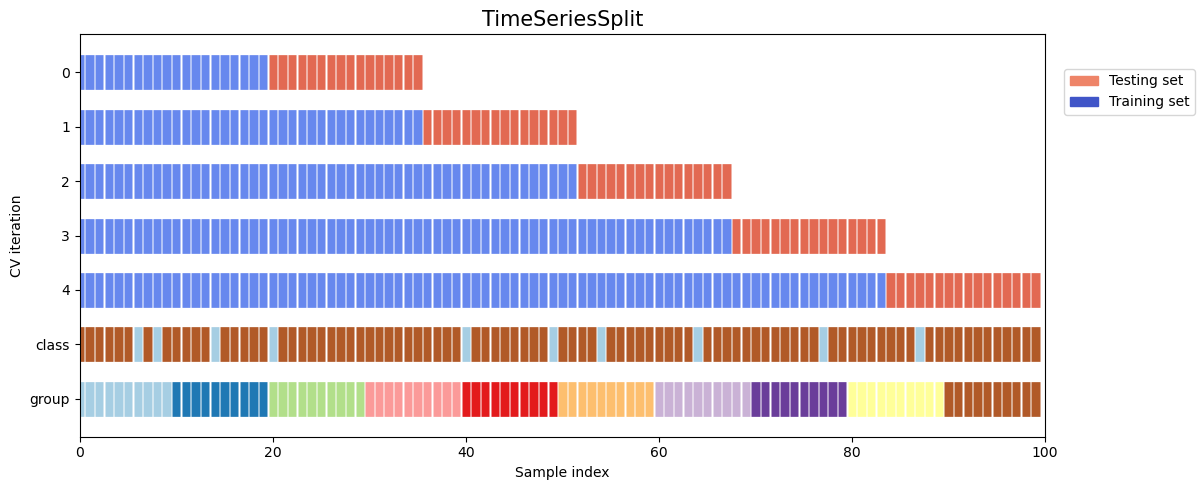

In [129]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)